In [35]:
import numpy as np
import scipy.stats as sps
import cvxpy as cvx
from PIL import Image
import matplotlib.pyplot as plt

Реализуем алгоритм из статьи.

In [36]:
def CAMNS_LP(X, N=3, tol=1e-3):
    L, M = X.shape
    
    d = (X @ np.ones((M, 1)) / M).flatten()
    [C, Sigma, V] = np.linalg.svd(X - d.reshape(-1, 1), full_matrices=False)
    C= C[:, : N - 1]
    #------------Step 1
    el = 0
    B = np.diag(np.ones(L))
    while el < N: #--------------Step 7
        #--------------Step 2
        w = sps.norm.rvs(size=L)
        r = B @ w

        #--------------Step 3
        alpha = cvx.Variable(C.shape[1])
        min_problem = cvx.Problem(cvx.Minimize(r.T @ (C @ alpha + d)), [C @ alpha + d >= 0])
        max_problem = cvx.Problem(cvx.Maximize(r.T @ (C @ alpha + d)), [C @ alpha + d >= 0])
        
        p_star = min_problem.solve()
        alpha1_star = alpha.value
        
        q_star = max_problem.solve()
        alpha2_star = alpha.value
        
        #--------------Step 4
        if el == 0:
            if abs(p_star) >= tol and abs(q_star) >= tol:
                hS = np.column_stack((C @ alpha1_star + d, C @ alpha2_star + d))
            elif abs(p_star) >= tol:
                hS = C @ alpha1_star + d
            elif abs(q_star) >= tol:
                hS = C @ alpha2_star + d
        else:
            if abs(p_star) >= tol:
                hS = np.column_stack((hS, C @ alpha1_star + d))
            
            if abs(q_star) >= tol:
                hS = np.column_stack((hS, C @ alpha2_star + d))
        #--------------Step 5
        el = hS.shape[1]
        if el >= N:
            break
        #--------------Step 6
        Q, R = np.linalg.qr(np.array(hS))
        B = np.diag(np.ones(L)) - Q @ Q.T
        
    return hS

Функция для смешивания картинок.

In [37]:
def mix(img_names, coef):
    plt.figure(figsize=(15, 10))
    imgs = []
    for img_name in img_names:
        img = np.array(Image.open('img/' + img_name).convert('L'))
        width, height = img.shape
        imgs.append(img.flatten())

    imgs = np.array(imgs)
    for i in range(len(coef)):
        mixed_img = coef[i] @ imgs
        mixed_img_to_show = mixed_img.reshape(width, height)
        imgs[i] = mixed_img
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(mixed_img_to_show)
    plt.show()
    
    return imgs, width, height

In [41]:
def get_unmixed_imgs(S, width, height):
    plt.figure(figsize=(15, 10))
    S = S.T
    for i in range(S.shape[0]):
        img = S[i]
        img = img.reshape(height, width)
        ax = plt.subplot(1, S.shape[0], i + 1)
        ax.imshow(img)
    plt.show()

Проверим работоспособность алгоритма.

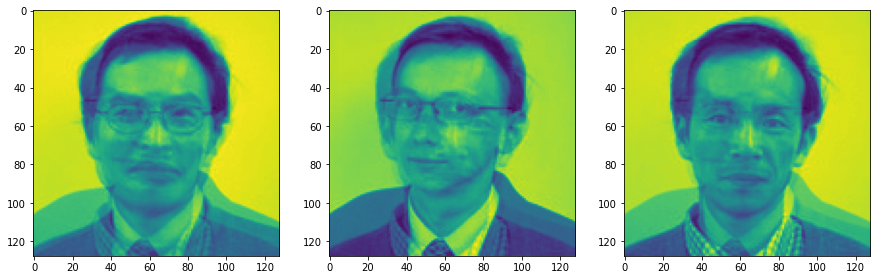

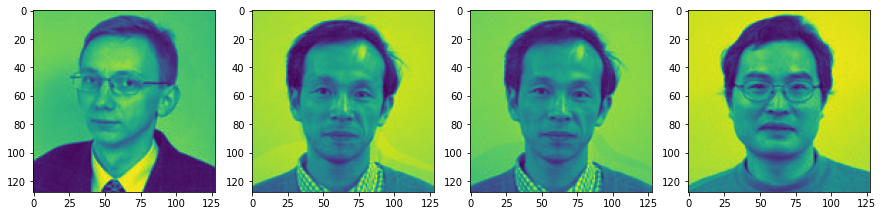

In [42]:
mix_coefs = np.array([[0.5, 0.25, 0.25], [0.25, 0.5, 0.25], [0.25, 0.25, 0.5]])
sources = ['cao1.jpg', 'ksiwek1.jpg', 'zhang1.jpg']

X, width, height = mix(sources, mix_coefs)

X = np.array(X).T
S = CAMNS_LP(X)

get_unmixed_imgs(S, width, height)